In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx



In [5]:
conda install -c conda-forge cvxpy

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
import cvxpy as cp

In [4]:
df = pd.read_csv("/Users/ishaanchansarkar/Downloads/flag.csv")

In [5]:
Y_correct = df['Religion']
print(Y_correct.unique())

[2 6 1 0 5 3 4 7]


In [6]:
import random
indices = []
for i in range(194):
    indices.append(i)

labeled_indices = random.sample(indices, 100)
unlabeled_indices = []

for j in indices:
    if labeled_indices.count(j) == 0:
        unlabeled_indices.append(j)



In [7]:
df_filter = df[['Landmass', 'Language', 'Red', 'Green', 'Blue', 'Gold',
              'White', 'Black', 'Orange', 'Crosses', 'Sunstars']]
df_filter

,Landmass,Language,Red,Green,Blue,Gold,White,Black,Orange,Crosses,Sunstars
0,5,10,1,1,0,1,1,1,0,0,1
1,3,6,1,0,0,1,0,1,0,0,1
2,4,8,1,1,0,0,1,0,0,0,1
3,6,1,1,0,1,1,1,0,1,0,0
4,3,6,1,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
189,6,1,1,0,1,0,1,0,0,0,5
190,3,6,1,0,1,1,1,0,0,0,1
191,4,10,1,1,0,1,0,0,1,0,0
192,4,10,1,1,0,0,0,1,1,0,0


In [8]:
Y = np.zeros(100)
X = np.zeros((194, 11))
Y_true = np.zeros(94)
Y_buff = np.zeros(94)
arr = np.asarray(df_filter)


for i in range(100):
    Y[i] = Y_correct[labeled_indices[i]]
    X[i] = arr[labeled_indices[i]]
    
for j in range(94):
    X[100 + j] = arr[unlabeled_indices[j]]
    Y_true[j] = Y_correct[unlabeled_indices[j]]
    


In [9]:
Y_combined = np.concatenate((Y, Y_buff), axis = 0)
Y_combined

array([1., 2., 0., 2., 0., 2., 1., 1., 1., 0., 1., 2., 1., 2., 1., 6., 5.,
       1., 2., 0., 0., 5., 0., 6., 1., 1., 2., 3., 1., 1., 2., 2., 6., 5.,
       2., 2., 1., 3., 5., 0., 0., 1., 0., 3., 0., 0., 5., 5., 4., 0., 2.,
       5., 2., 6., 2., 3., 2., 1., 6., 0., 0., 5., 1., 2., 0., 6., 5., 7.,
       6., 1., 4., 7., 7., 1., 1., 5., 7., 0., 2., 1., 1., 5., 0., 5., 6.,
       0., 1., 1., 1., 0., 1., 1., 1., 5., 2., 2., 6., 2., 2., 6., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [37]:
def sim(i, j):
    s = 0
    if df_filter.iloc[i, 0] == df_filter.iloc[j, 0]:
        s += 10
    if df_filter.iloc[i, 1] == df_filter.iloc[j, 1]:
        s += 20
    for k in range(7):
        if df_filter.iloc[i, k+2] == df_filter.iloc[j, k+2]:
            s += 4
    s += 10 * (df_filter.iloc[i, 9] * df_filter.iloc[j, 9])
    s += df_filter.iloc[i, 10] + df_filter.iloc[j, 10]
    return s

  
    
        
def dist(i, j): 
    dist = []
    for ind in range(11):
        dist.append((df_filter.iloc[i, ind] - df_filter.iloc[j, ind])**2)
    #if(sum(dist)==0):
    #    return 0.001
    return np.sqrt(sum(dist))




In [38]:
similarity = np.zeros((194, 194))
dists = np.zeros((194, 194))

for i in range(194):
    for j in range(194):
        if i != j:
            similarity[i, j] = sim(i, j)
            dists[i, j] = dist(i, j)
        else:
            dists[i, j] = 10

In [ ]:
def KNNgraph(n, s):
    weights = np.zeros((194, 194))
    for a in range(194):
        arr = s[a,:]
        tmp = np.argpartition(arr, -n)[-n:]
        ind = tmp[np.argsort((-arr)[tmp])]
        for b in ind:
            weights[a, b] = s[a, b]
            weights[b, a] = s[a, b]
    return weights


def neighborhoodGraph(eps, s):
    weights = np.zeros((194, 194))
    for a in range(194):
        for b in range(194):
            if dists[a, b] < eps:
                weights[a, b] = s[a, b]
                weights[b, a] = s[a, b]
    return weights

def bMatchingGraph(b):
    x = cp.Variable((194, 194), name='x')
    objective = sum(dists[a, b] * x[a, b] for a in range(194) for b in range(194))
    constraints = []
    constraints += [x == x.T]
    for s in range(194):
        constraints += [np.sum(x[s, :]) == b]
        constraints += [x[s, s] == 0]
        for t in range(194):
            constraints += [x[s, t]>=0]
            constraints += [x[s, t]<=1]
            

    prob = cp.Problem(cp.Minimize(objective), constraints)
   

    return prob

In [14]:
class GraphVisualization:

    def __init__(self):
        # visual is a list which stores all
        # the set of edges that constitutes a
        # graph
        self.visual = []

    # addEdge function inputs the vertices of an
    # edge and appends it to the visual list
    def addEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)

    # In visualize function G is an object of
    # class Graph given by networkx G.add_edges_from(visual)
    # creates a graph with a given list
    # nx.draw_networkx(G) - plots the graph
    # plt.show() - displays the graph
    def visualize(self):
        G = nx.Graph()
        G.add_edges_from(self.visual)
        nx.draw_networkx(G)
        plt.show()

In [ ]:
#w = KNNgraph(5, similarity)
prob = bMatchingGraph(5)

In [53]:
prob.solve(solver=cp.OSQP)

SolverError: The solver SCIP is not installed.

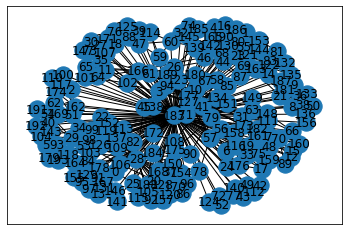

In [15]:
G = GraphVisualization()

for i in range(194):
    for j in range(194):
        if w[i, j] != 0:
            G.addEdge(i, j)

G.visualize()

In [16]:
degree = np.zeros((194, 194))
for i in range(194):
    degree[i][i] = sum(w[i,:])

In [17]:
laplacian = degree - w


In [18]:
from numpy.linalg import matrix_power, inv
#norm_laplacian = np.power(degree, -1/2) @ laplacian @ np.power(degree, -1/2)

In [19]:
t = np.sqrt((np.linalg.inv(degree)))
norm_laplacian = t @ laplacian @ t

In [198]:
Y_embed = np.zeros(194)
s = 0
for i in range(194):
    s += np.norm(Y_combined[i] - (w[i,:].dot(Y_combined)))**2
 

AttributeError: module 'numpy' has no attribute 'norm'

In [119]:
Y_embed

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [199]:
duu = degree[100:, 100:]
wuu = w[100:, 100:]
wul = w[100:, :100]
k = np.linalg.inv(duu - wuu) @ wul
pred = k @ Y
#pred2 = np.matrix.round(pred)

In [200]:
Y_true

array([2., 1., 0., 1., 1., 0., 1., 1., 1., 5., 0., 6., 5., 1., 0., 1., 5.,
       6., 0., 2., 6., 1., 1., 1., 0., 0., 2., 1., 1., 1., 1., 0., 0., 5.,
       1., 5., 1., 1., 1., 1., 1., 2., 5., 4., 0., 0., 3., 6., 1., 4., 2.,
       1., 5., 2., 2., 0., 2., 2., 0., 1., 1., 1., 0., 2., 6., 2., 2., 0.,
       5., 0., 6., 0., 6., 5., 5., 1., 2., 1., 7., 3., 1., 1., 2., 5., 3.,
       2., 1., 2., 1., 0., 1., 6., 6., 5.])

In [201]:
%pip install -i https://pypi.gurobi.com gurobipy;
import gurobipy

Looking in indexes: https://pypi.gurobi.com
Note: you may need to restart the kernel to use updated packages.


In [179]:
#GRF algorithm: results seem pretty bad, calculating the average class of a node's neighbors
#does not seem viable for classification problems.

for i in range(10):
    w = KNNgraph(i, similarity)
   
    degree = np.zeros((194, 194))
    for i in range(194):
        degree[i][i] = sum(w[i,:])
    duu = degree[100:, 100:]
    wuu = w[100:, 100:]
    wul = w[100:, :100]
    k = np.linalg.inv(duu - wuu) @ wul
    pred = k @ Y     
    print(np.sum(np.abs(Y_true - pred))/94)
    
    
    


1.6986705883268416
1.6639860848429078
1.7726658772673958
1.7805497316367864
1.772026659051767
1.7698872952817053
1.7479496270956545
1.7327295685781785
1.7386949090174622
1.7493681362431697


In [20]:
degree

array([[276.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., 279.,   0., ...,   0.,   0.,   0.],
       [  0.,   0., 384., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., 267.,   0.,   0.],
       [  0.,   0.,   0., ...,   0., 263.,   0.],
       [  0.,   0.,   0., ...,   0.,   0., 335.]])

In [54]:
#Solving with LGC algorithm: slightly better result than GRF
def LGC(w, deg):
    y_pred = cp.Variable(194)
    objective = 0
    constraints = []
    for i in range(194):
        constraints += [y_pred[i] >=0]
        constraints += [y_pred[i] <=7]
    
        for j in range(194):
            t = w[i, j]*((1/np.sqrt(deg[i,i])*y_pred[i]) - (1/np.sqrt(deg[j, j])*y_pred[j]))**2
            objective += t
    objective += sum((y_pred[:100] - Y)**2)
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.OSQP)
    return y_pred.value
    






In [24]:
import gurobipy
prob = cp.Problem(cp.Minimize(objective), constraints)


In [25]:
prob.solve(solver=cp.OSQP)

382.7613020600859

In [27]:
print(y_pred.value)

[1.01537441 1.77687072 1.04463109 1.49128546 1.23500191 1.48794347
 1.20595933 1.50541707 1.18301873 1.22323239 1.75939517 1.76819044
 1.4037614  1.74990072 1.44384252 2.95293856 2.64524576 1.24782139
 2.09497974 1.13501255 0.65567246 2.81822538 0.87088141 4.91049263
 1.29886751 1.00688876 1.40080911 2.39023754 2.60176966 1.76908803
 2.08154992 1.55869311 3.05296802 3.02350165 1.73384316 1.7698669
 1.37833674 1.81473617 2.82268694 0.98849282 0.97136586 2.94926523
 0.78586583 2.06608793 0.99864513 0.70317004 3.05268911 2.53711371
 3.27903675 0.7353376  1.88789432 2.51831652 1.75168986 3.08017229
 1.4286952  2.59825789 1.7124963  1.95572152 2.91627241 0.99505774
 0.90092738 2.39809725 1.06281692 1.5652529  1.12943824 2.87223203
 2.62841179 3.1937693  3.67205424 1.37760222 2.78054345 3.15219251
 3.23767117 1.40118578 1.62129358 2.56866638 3.15928772 1.27429035
 1.44451937 1.23301196 1.91886851 2.80551584 0.63253786 2.9478275
 3.65319239 0.8925983  1.29406063 1.69117277 1.38510263 1.120626

In [31]:
p = y_pred.value
print(np.sum(np.abs(Y_true - p[100:]))/94)

1.4543170595463244


In [33]:
print(np.matrix.round(p))

[1. 2. 1. 1. 1. 1. 1. 2. 1. 1. 2. 2. 1. 2. 1. 3. 3. 1. 2. 1. 1. 3. 1. 5.
 1. 1. 1. 2. 3. 2. 2. 2. 3. 3. 2. 2. 1. 2. 3. 1. 1. 3. 1. 2. 1. 1. 3. 3.
 3. 1. 2. 3. 2. 3. 1. 3. 2. 2. 3. 1. 1. 2. 1. 2. 1. 3. 3. 3. 4. 1. 3. 3.
 3. 1. 2. 3. 3. 1. 1. 1. 2. 3. 1. 3. 4. 1. 1. 2. 1. 1. 1. 2. 1. 3. 2. 2.
 3. 2. 2. 3. 1. 2. 1. 1. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 2. 1. 1. 1.
 1. 2. 2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2.
 2. 2. 2. 2. 2. 1. 1. 1. 1. 2. 1. 2. 2. 1. 1. 2. 2. 1. 2. 2. 1. 2. 2. 2.
 1. 1. 2. 2. 1. 1. 2. 1. 2. 3. 2. 2. 2. 2. 2. 7. 1. 2. 2. 2. 1. 1. 2. 1.
 1. 2.]


In [ ]:
for i in range(10):
    w = KNNgraph(i, similarity)
    deg = np.zeros((194, 194))
    for i in range(194):
        deg[i][i] = sum(w[i,:])
    val = LGC(w, deg)
    print(np.sum(np.abs(Y_true - val[100:]))/94)
    

1.6010390283727496
1.8784875752373553
1.7514597624804702
1.6353023433964868
1.6218159025328516
1.6071887019285482
1.6169534822652751
1.6274120394442322
